### Train and Test 

In [1]:

# import MAE
from sklearn import metrics

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# use test_train_split from sklearn
from sklearn.model_selection import train_test_split
import csv
# import solar_data.csv use a single column and store each value in a row
solar_dataset = []
# read values as float
with open('solar_data.csv', 'r') as f:
    reader = csv.reader(f)
    solar_dataset = list(reader)
    
    
solar_dataset = np.array(solar_dataset).astype(float)


In [4]:
solar_dataset_single = solar_dataset[0].shape

In [5]:
# plot solar_dataset
import numpy as np

# Assuming you have the whole dataset stored in a variable named 'whole_dataset'

# Split the data into input and target signals
input_dataset = solar_dataset[:, :-1]
target_dataset = solar_dataset[:, 1:]

# Split the data into training and test sets take the first 2398 time steps
training_input = input_dataset[:2398]
training_target = target_dataset[:2398]

# last 500 time steps for testing
test_input = input_dataset[2398:2898]  # 500 time steps for testing
test_target = target_dataset[2398:2898]

# Verify shapes
print("Training Input Shape:", training_input.shape)
print("Training Target Shape:", training_target.shape)
print("Test Input Shape:", test_input.shape)
print("Test Target Shape:", test_target.shape)



Training Input Shape: (1, 2898)
Training Target Shape: (1, 2898)
Test Input Shape: (0, 2898)
Test Target Shape: (0, 2898)


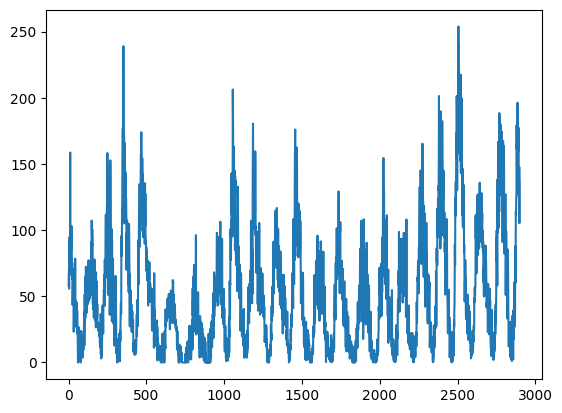

In [6]:
for i in range(0, len(solar_dataset)):
    plt.plot(solar_dataset[i])
        
plt.show()

### Split avaiable data

In [7]:
# Squeeze the dimensions of the target arrays
training_target = np.squeeze(training_target)

input_dataset = np.squeeze(input_dataset)
target_dataset = np.squeeze(target_dataset)



#input_dataset = solar_dataset[:, :-1]
#target_dataset = solar_dataset[:, 1:]



In [8]:
# take 2098 to train, then 300 for validation and 500 for testing
input_training, input_validation, input_testing = input_dataset[:2098], input_dataset[2098:2398], input_dataset[2398:2898]
target_training, target_validation, target_testing = target_dataset[:2098], target_dataset[2098:2398], target_dataset[2398:2898]


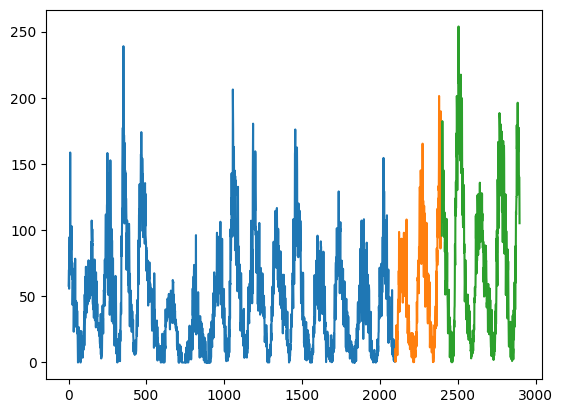

In [9]:
plt.plot(input_training)
# Append in the graph after the training data the validation data skip for plotting validation the first len(input_training) values 
plt.plot(np.arange(len(input_training), len(input_training) + len(input_validation)), input_validation)
plt.plot(np.arange(len(input_training) + len(input_validation), len(input_training) + len(input_validation) + len(input_testing)), input_testing)

In [10]:
# Verify shapes
print("Training Input Shape:", input_training.shape)
print("Training Target Shape:", target_training.shape)
print("Validation Input Shape:", input_validation.shape)
print("Validation Target Shape:", target_validation.shape)
print("Test Input Shape:", input_testing.shape)
print("Test Target Shape:", target_testing.shape)


Training Input Shape: (2098,)
Training Target Shape: (2098,)
Validation Input Shape: (300,)
Validation Target Shape: (300,)
Test Input Shape: (500,)
Test Target Shape: (500,)


In [11]:

# Divide data in train, valid, test
#train_data, test_data = train_test_split(solar_data, test_size=0.2, random_state=42)

# Divide train data in train and valid
#train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=42)


In [12]:
def LiquidStateMachine(Ne, Ni, win_e, win_i, w_e, w_i, input=None):
    # Excitatory neurons    Inhibitory neurons
    
    #NOTE Ne is excitatory units and Ni is inhibitory units
    #NOTE a,b,c,d are parameters for those units
    Ne = Ne
    Ni = Ni
    re = np.random.rand(Ne)
    ri = np.random.rand(Ni)
    a = np.concatenate((0.02*np.ones(Ne), 0.02+0.08*ri))
    b = np.concatenate((0.2*np.ones(Ne), 0.25-0.05*ri))
    c = np.concatenate((-65+15*re**2, -65*np.ones(Ni)))
    d = np.concatenate((8-6*re**2, 2*np.ones(Ni)))

    #NOTE Inputs that comes from other neurons, matrix U project input into the "pull of neurons" in the mateix U we have random weights
    #NOTE So matrix U doens't learn just project in a lower space
    
    #NOTE Matrix S couples the neurons with each others
    
    # scaling of input connections
    win_e = win_e
    win_i = win_i
    U = np.concatenate((win_e*np.ones(Ne), win_i*np.ones(Ni)))

    # scaling of recurrent connections
    w_e = w_e
    w_i = w_i
    S = np.concatenate((w_e*np.random.rand(Ne+Ni, Ne), -w_i*np.random.rand(Ne+Ni, Ni)), axis=1)

    v = -65*np.ones(Ne+Ni)  # Initial values of v
    u = b*v  # Initial values of u
    firings = []  # spike timings
    states = []  # here we construct the matrix of reservoir states

    for t in range(len(input)):  # simulation of 1000 ms
        # we don't need random thalamic input:
        # I = np.concatenate((5*np.random.randn(Ne), 2*np.random.randn(Ni)))  # thalamic input
        # we use instead the input from the external time series!
        I = input[t] * U
        fired = np.where(v >= 30)[0]  # indices of spikes
        firings.append(np.column_stack((t+np.zeros_like(fired), fired)))
        v[fired] = c[fired]
        u[fired] = u[fired] + d[fired]
        
        #NOTE Here we select the neurons that are firing (S contains connection from a neuron to any other neuron)
        #NOTE There is a pull of different neurons (some noise that makes neurons a little diverse from each other)
        
        
        I = I + np.sum(S[:, fired], axis=1)
        v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # step 0.5 ms
        v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability
        u = u + a*(b*v - u)
        
        #NOTE State can be anything (like a firing rate)
        states.append(v >= 30)

    firings = np.concatenate(firings)
    plt.plot(firings[:, 0], firings[:, 1], '.')

    # in the end states is 1000 x number of time steps
    return states, firings

# Readout 

# Best params

Best MAE: 33.51738248979964
Best Hyperparameters: {('Ne', 'Ni'): 70, 'win_e': 1, 'win_i': 10, 'w_e': 0.5, 'w_i': 1.0}

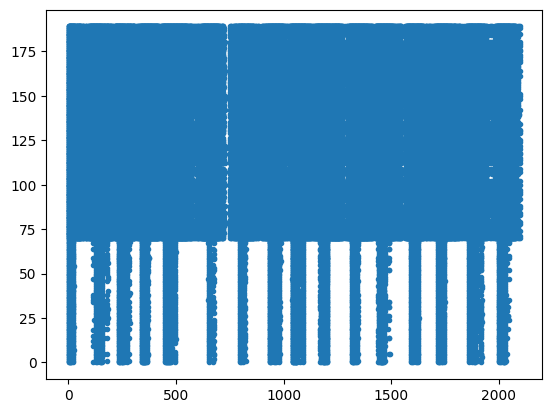

In [31]:

#train_states, train_firings = LiquidStateMachine(Ne=400, Ni=600, win_e = 1.2, win_i = 1.5, w_e = 0.75, w_i = 0.9, input=input_training)

train_states, train_firings = LiquidStateMachine(Ne=70, Ni=120, win_e = 1, win_i = 10, w_e = 0.75, w_i = 0.75, input=input_training)

In [64]:
#train readout



state_mat = np.array(train_states).T

Wout = target_training @ np.linalg.pinv(state_mat)

trainOutput = Wout @ state_mat



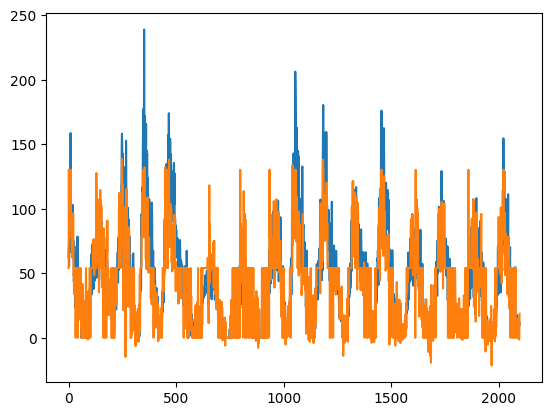

In [65]:
#plot all the train output

plt.plot(target_training)
plt.plot(trainOutput)



# Compute MAE against training

In [66]:
# compute mae of X and trainOutput

metrics.mean_absolute_error(mlpOutput, target_training)
#metrics.mean_absolute_error(predicted, test)

16.79655513298716

In [67]:
Wout.shape

(190,)

34.23257902312363

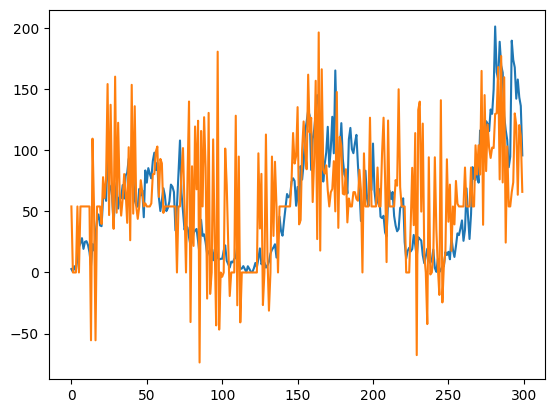

In [68]:
# Mean Absolute Error
# try validation data
#val_states, val_firings = LiquidStateMachine(Ne=300, Ni=700, win_e = 2, win_i = 10, w_e = 0.5, w_i = 0.1, input=input_validation)

val_states, val_firings = LiquidStateMachine(Ne=70, Ni=120, win_e = 1, win_i = 10, w_e = 0.75, w_i = 0.75, input=input_validation)

val_states_mat = np.array(val_states).T

valOutput = Wout @ val_states_mat

# clear plots
plt.clf()

plt.plot(target_validation)
plt.plot(valOutput)

metrics.mean_absolute_error(valOutput, input_validation)

Best MAE: 33.51738248979964
Best Hyperparameters: {('Ne', 'Ni'): 70, 'win_e': 1, 'win_i': 10, 'w_e': 0.5, 'w_i': 1.0}

Best MAE: 29.560121212820533
Best Hyperparameters: {('Ne', 'Ni'): 70, 'win_e': 1, 'win_i': 10, 'w_e': 0.75, 'w_i': 0.75}

In [28]:
import os
import json
# Let's implement a random search for win_e, win_i, w_e, w_i

# Defintion of the search space with a dictionary 
search_space = {
    ('Ne', 'Ni'): [(70, 120), (120, 70), (100, 100)],
    'win_e': [1, 5, 10, 15, 40, 70],
    'win_i': [5, 10, 15, 20, 30, 50],
    'w_e': [0.05, 0.10, 0.25, 0.5, 0.75, 1],
    'w_i': [0.1, 0.5, 0.75, 1, 1.25]
}


def random_search():
    # Random search
    best_mae = np.inf
    best_params = None



    # Read checked_params from a file
    if not os.path.exists("checked_params.txt"):
        checked_params = []
    else:
        with open("checked_params.txt", "r") as f:
            checked_params = json.loads(f.read())

    for i in range(25):
        # Sample random hyperparameters
        
        # generate params and check if they are used before
        params = {
            # Chose a certain tuple from the search space
            ('Ne', 'Ni'): np.random.choice(np.ravel(search_space[('Ne', 'Ni')])),
            'win_e': np.random.choice(search_space['win_e']),
            'win_i': np.random.choice(search_space['win_i']),
            'w_e': np.random.choice(search_space['w_e']),
            'w_i': np.random.choice(search_space['w_i'])
        }
        
        while params in checked_params:
            
            params = {
                ('Ne', 'Ni'): np.random.choice(np.ravel(search_space[('Ne', 'Ni')])),
                'win_e': np.random.choice(search_space['win_e']),
                'win_i': np.random.choice(search_space['win_i']),
                'w_e': np.random.choice(search_space['w_e']),
                'w_i': np.random.choice(search_space['w_i'])
            }
    
        # save params in a list for each iteration
        checked_params.append(params)        
            
        print("-" * 50)
        print("Iteration:", i)
        print(f"Trying hyperparameters: {params}")
        
        # Print Ne, Ni values
        Ni =  np.ravel(params[('Ne', 'Ni')])[0]
        Ne = 1000-Ni
    
        # Train the LSM with the hyperparameters
        train_states, train_firings = LiquidStateMachine(Ne=Ne, Ni=Ni, win_e=params['win_e'], win_i=params['win_i'], w_e=params['w_e'], w_i=params['w_i'], input=input_training)
        state_mat = np.array(train_states).T
        Wout = target_training @ np.linalg.pinv(state_mat)
        trainOutput = Wout @ state_mat

        # Compute the MAE on the validation set
        val_states, val_firings = LiquidStateMachine(Ne=Ne, Ni=Ni, win_e=params['win_e'], win_i=params['win_i'], w_e=params['w_e'], w_i=params['w_i'], input=input_validation)

        val_states_mat = np.array(val_states).T

        valOutput = Wout @ val_states_mat

        mae = metrics.mean_absolute_error(valOutput, input_validation)

        # Update the best MAE and best hyperparameters
        if mae < best_mae:
            best_mae = mae
            best_params = params
            
        print(f"MAE of {mae} with hyperparameters: {params}", end="\n\n")
        print("-" * 50)
        

    return best_mae, best_params, checked_params



--------------------------------------------------
Iteration: 0
Trying hyperparameters: {('Ne', 'Ni'): 120, 'win_e': 70, 'win_i': 5, 'w_e': 0.25, 'w_i': 0.1}


C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: overflow encountered in square
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability
C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: invalid value encountered in add
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability


MAE of 137068277175.71013 with hyperparameters: {('Ne', 'Ni'): 120, 'win_e': 70, 'win_i': 5, 'w_e': 0.25, 'w_i': 0.1}

--------------------------------------------------
--------------------------------------------------
Iteration: 1
Trying hyperparameters: {('Ne', 'Ni'): 70, 'win_e': 1, 'win_i': 10, 'w_e': 0.75, 'w_i': 0.75}
MAE of 29.560121212820533 with hyperparameters: {('Ne', 'Ni'): 70, 'win_e': 1, 'win_i': 10, 'w_e': 0.75, 'w_i': 0.75}

--------------------------------------------------
--------------------------------------------------
Iteration: 2
Trying hyperparameters: {('Ne', 'Ni'): 100, 'win_e': 5, 'win_i': 5, 'w_e': 0.05, 'w_i': 0.75}
MAE of 282.92799420875883 with hyperparameters: {('Ne', 'Ni'): 100, 'win_e': 5, 'win_i': 5, 'w_e': 0.05, 'w_i': 0.75}

--------------------------------------------------
--------------------------------------------------
Iteration: 3
Trying hyperparameters: {('Ne', 'Ni'): 70, 'win_e': 10, 'win_i': 20, 'w_e': 0.25, 'w_i': 0.75}
MAE of 189.8995

C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: overflow encountered in square
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability
C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: invalid value encountered in add
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability


MAE of 41.80565779852532 with hyperparameters: {('Ne', 'Ni'): 100, 'win_e': 1, 'win_i': 50, 'w_e': 0.5, 'w_i': 1.25}

--------------------------------------------------
--------------------------------------------------
Iteration: 5
Trying hyperparameters: {('Ne', 'Ni'): 70, 'win_e': 5, 'win_i': 15, 'w_e': 1.0, 'w_i': 1.0}
MAE of 156.4085206254456 with hyperparameters: {('Ne', 'Ni'): 70, 'win_e': 5, 'win_i': 15, 'w_e': 1.0, 'w_i': 1.0}

--------------------------------------------------
--------------------------------------------------
Iteration: 6
Trying hyperparameters: {('Ne', 'Ni'): 70, 'win_e': 5, 'win_i': 5, 'w_e': 0.75, 'w_i': 1.0}
MAE of 184.2991036140477 with hyperparameters: {('Ne', 'Ni'): 70, 'win_e': 5, 'win_i': 5, 'w_e': 0.75, 'w_i': 1.0}

--------------------------------------------------
--------------------------------------------------
Iteration: 7
Trying hyperparameters: {('Ne', 'Ni'): 100, 'win_e': 70, 'win_i': 30, 'w_e': 0.05, 'w_i': 1.0}


C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: overflow encountered in square
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability
C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: invalid value encountered in add
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability


MAE of 35.35417958449052 with hyperparameters: {('Ne', 'Ni'): 100, 'win_e': 70, 'win_i': 30, 'w_e': 0.05, 'w_i': 1.0}

--------------------------------------------------
--------------------------------------------------
Iteration: 8
Trying hyperparameters: {('Ne', 'Ni'): 100, 'win_e': 70, 'win_i': 15, 'w_e': 0.5, 'w_i': 1.25}


C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: overflow encountered in square
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability
C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: invalid value encountered in add
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability


MAE of 33.671501627430374 with hyperparameters: {('Ne', 'Ni'): 100, 'win_e': 70, 'win_i': 15, 'w_e': 0.5, 'w_i': 1.25}

--------------------------------------------------
--------------------------------------------------
Iteration: 9
Trying hyperparameters: {('Ne', 'Ni'): 120, 'win_e': 40, 'win_i': 15, 'w_e': 0.05, 'w_i': 0.1}


C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: overflow encountered in square
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability
C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: invalid value encountered in add
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability


MAE of 198.85610223748844 with hyperparameters: {('Ne', 'Ni'): 120, 'win_e': 40, 'win_i': 15, 'w_e': 0.05, 'w_i': 0.1}

--------------------------------------------------
--------------------------------------------------
Iteration: 10
Trying hyperparameters: {('Ne', 'Ni'): 120, 'win_e': 10, 'win_i': 30, 'w_e': 1.0, 'w_i': 0.5}
MAE of 271.6200834992624 with hyperparameters: {('Ne', 'Ni'): 120, 'win_e': 10, 'win_i': 30, 'w_e': 1.0, 'w_i': 0.5}

--------------------------------------------------
--------------------------------------------------
Iteration: 11
Trying hyperparameters: {('Ne', 'Ni'): 100, 'win_e': 5, 'win_i': 5, 'w_e': 0.75, 'w_i': 1.0}
MAE of 65.33972654106158 with hyperparameters: {('Ne', 'Ni'): 100, 'win_e': 5, 'win_i': 5, 'w_e': 0.75, 'w_i': 1.0}

--------------------------------------------------
--------------------------------------------------
Iteration: 12
Trying hyperparameters: {('Ne', 'Ni'): 70, 'win_e': 40, 'win_i': 50, 'w_e': 0.25, 'w_i': 0.1}


C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: overflow encountered in square
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability
C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: invalid value encountered in add
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability


MAE of 646.1725043717912 with hyperparameters: {('Ne', 'Ni'): 70, 'win_e': 40, 'win_i': 50, 'w_e': 0.25, 'w_i': 0.1}

--------------------------------------------------
--------------------------------------------------
Iteration: 13
Trying hyperparameters: {('Ne', 'Ni'): 100, 'win_e': 5, 'win_i': 30, 'w_e': 0.5, 'w_i': 1.0}


C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: overflow encountered in square
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability
C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: invalid value encountered in add
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability


MAE of 52.650447327052454 with hyperparameters: {('Ne', 'Ni'): 100, 'win_e': 5, 'win_i': 30, 'w_e': 0.5, 'w_i': 1.0}

--------------------------------------------------
--------------------------------------------------
Iteration: 14
Trying hyperparameters: {('Ne', 'Ni'): 70, 'win_e': 40, 'win_i': 20, 'w_e': 0.25, 'w_i': 1.0}


C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: overflow encountered in square
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability
C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: invalid value encountered in add
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability


MAE of 380099182983.5587 with hyperparameters: {('Ne', 'Ni'): 70, 'win_e': 40, 'win_i': 20, 'w_e': 0.25, 'w_i': 1.0}

--------------------------------------------------
--------------------------------------------------
Iteration: 15
Trying hyperparameters: {('Ne', 'Ni'): 120, 'win_e': 40, 'win_i': 15, 'w_e': 0.05, 'w_i': 0.5}


C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: overflow encountered in square
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability
C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: invalid value encountered in add
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability


MAE of 283.9345620328632 with hyperparameters: {('Ne', 'Ni'): 120, 'win_e': 40, 'win_i': 15, 'w_e': 0.05, 'w_i': 0.5}

--------------------------------------------------
--------------------------------------------------
Iteration: 16
Trying hyperparameters: {('Ne', 'Ni'): 100, 'win_e': 40, 'win_i': 50, 'w_e': 0.25, 'w_i': 0.5}


C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: overflow encountered in square
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability
C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: invalid value encountered in add
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability


MAE of 1957.1851757692953 with hyperparameters: {('Ne', 'Ni'): 100, 'win_e': 40, 'win_i': 50, 'w_e': 0.25, 'w_i': 0.5}

--------------------------------------------------
--------------------------------------------------
Iteration: 17
Trying hyperparameters: {('Ne', 'Ni'): 120, 'win_e': 1, 'win_i': 10, 'w_e': 0.75, 'w_i': 0.1}
MAE of 37.803413646785415 with hyperparameters: {('Ne', 'Ni'): 120, 'win_e': 1, 'win_i': 10, 'w_e': 0.75, 'w_i': 0.1}

--------------------------------------------------
--------------------------------------------------
Iteration: 18
Trying hyperparameters: {('Ne', 'Ni'): 70, 'win_e': 15, 'win_i': 50, 'w_e': 0.25, 'w_i': 0.1}


C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: overflow encountered in square
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability
C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: invalid value encountered in add
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability


MAE of 614.7983689116252 with hyperparameters: {('Ne', 'Ni'): 70, 'win_e': 15, 'win_i': 50, 'w_e': 0.25, 'w_i': 0.1}

--------------------------------------------------
--------------------------------------------------
Iteration: 19
Trying hyperparameters: {('Ne', 'Ni'): 120, 'win_e': 5, 'win_i': 30, 'w_e': 1.0, 'w_i': 0.75}


C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: overflow encountered in square
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability
C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: invalid value encountered in add
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability


MAE of 1092.432947919039 with hyperparameters: {('Ne', 'Ni'): 120, 'win_e': 5, 'win_i': 30, 'w_e': 1.0, 'w_i': 0.75}

--------------------------------------------------
--------------------------------------------------
Iteration: 20
Trying hyperparameters: {('Ne', 'Ni'): 100, 'win_e': 15, 'win_i': 15, 'w_e': 0.1, 'w_i': 0.75}
MAE of 1338.7145988271564 with hyperparameters: {('Ne', 'Ni'): 100, 'win_e': 15, 'win_i': 15, 'w_e': 0.1, 'w_i': 0.75}

--------------------------------------------------
--------------------------------------------------
Iteration: 21
Trying hyperparameters: {('Ne', 'Ni'): 120, 'win_e': 70, 'win_i': 20, 'w_e': 0.1, 'w_i': 1.25}


C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: overflow encountered in square
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability
C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: invalid value encountered in add
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability


MAE of 41.98412237702333 with hyperparameters: {('Ne', 'Ni'): 120, 'win_e': 70, 'win_i': 20, 'w_e': 0.1, 'w_i': 1.25}

--------------------------------------------------
--------------------------------------------------
Iteration: 22
Trying hyperparameters: {('Ne', 'Ni'): 70, 'win_e': 70, 'win_i': 30, 'w_e': 0.5, 'w_i': 0.75}


C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: overflow encountered in square
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability
C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: invalid value encountered in add
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability


MAE of 37.76809826453162 with hyperparameters: {('Ne', 'Ni'): 70, 'win_e': 70, 'win_i': 30, 'w_e': 0.5, 'w_i': 0.75}

--------------------------------------------------
--------------------------------------------------
Iteration: 23
Trying hyperparameters: {('Ne', 'Ni'): 70, 'win_e': 5, 'win_i': 5, 'w_e': 0.5, 'w_i': 0.5}
MAE of 34.828157915066086 with hyperparameters: {('Ne', 'Ni'): 70, 'win_e': 5, 'win_i': 5, 'w_e': 0.5, 'w_i': 0.5}

--------------------------------------------------
--------------------------------------------------
Iteration: 24
Trying hyperparameters: {('Ne', 'Ni'): 120, 'win_e': 5, 'win_i': 50, 'w_e': 0.5, 'w_i': 1.25}


C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: overflow encountered in square
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability
C:\Users\cenzo\AppData\Local\Temp\ipykernel_5788\4013030889.py:51: RuntimeWarning: invalid value encountered in add
  v = v + 0.5*(0.04*v**2 + 5*v + 140 - u + I)  # for numerical stability


MAE of 56.59796870248872 with hyperparameters: {('Ne', 'Ni'): 120, 'win_e': 5, 'win_i': 50, 'w_e': 0.5, 'w_i': 1.25}

--------------------------------------------------


TypeError: keys must be str, int, float, bool or None, not tuple

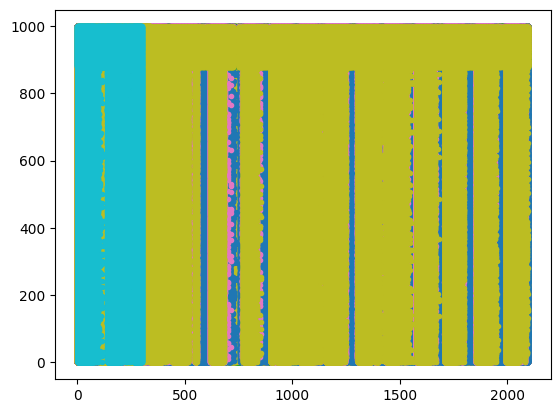

In [29]:
best_mae, best_params, checked_params = random_search()

# Save checked_params to a file
with open("checked_params.txt", "w") as f:
    f.write(json.dumps(checked_params))

In [30]:
print("Best MAE:", best_mae)
print("Best Hyperparameters:", best_params)




Best MAE: 29.560121212820533
Best Hyperparameters: {('Ne', 'Ni'): 70, 'win_e': 1, 'win_i': 10, 'w_e': 0.75, 'w_i': 0.75}


In [ ]:
#Trying hyperparameters: {'win_e': 1, 'win_i': 1, 'w_e': 0.5, 'w_i': 0.1}
#MAE of 111.17964210132976 with hyperparameters: {'win_e': 1, 'win_i': 1, 'w_e': 0.5, 'w_i': 0.1}